# Wine Quality EDA (Regression task)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# Import data from local files
df_white = pd.read_csv('Data/winequality-white.csv')
df_red = pd.read_csv('Data/winequality-red.csv')

In [3]:
# Function to clean wine quality datasets
def clean_wine_df(df):
    # Column headings are concatenated; need to split each feature into a list
    cols_string = list(df.columns)[0]
    cols_list = cols_string.replace('\"', '').split(";")

    # Split up concatenated sample values and cast to numeric type
    rows_str_list = df[cols_string].to_list() # Holds each row as a string
    rows_str_list = [x.split(";") for x in rows_str_list] # Holds each row as a list of strings
    rows_float_list = [[float(y) for y in x] for x in rows_str_list] # Cast every element to float

    # Combine cleaned rows and columns into a new dataframe
    df = pd.DataFrame(rows_float_list, columns = cols_list)
    
    return df


In [4]:
# Apply cleaning to both datasets
df_white = clean_wine_df(df_white)
df_red = clean_wine_df(df_red)

df_white.to_csv("Data/clean-winequality-white.csv")
df_red.to_csv("Data/clean-winequality-red.csv")

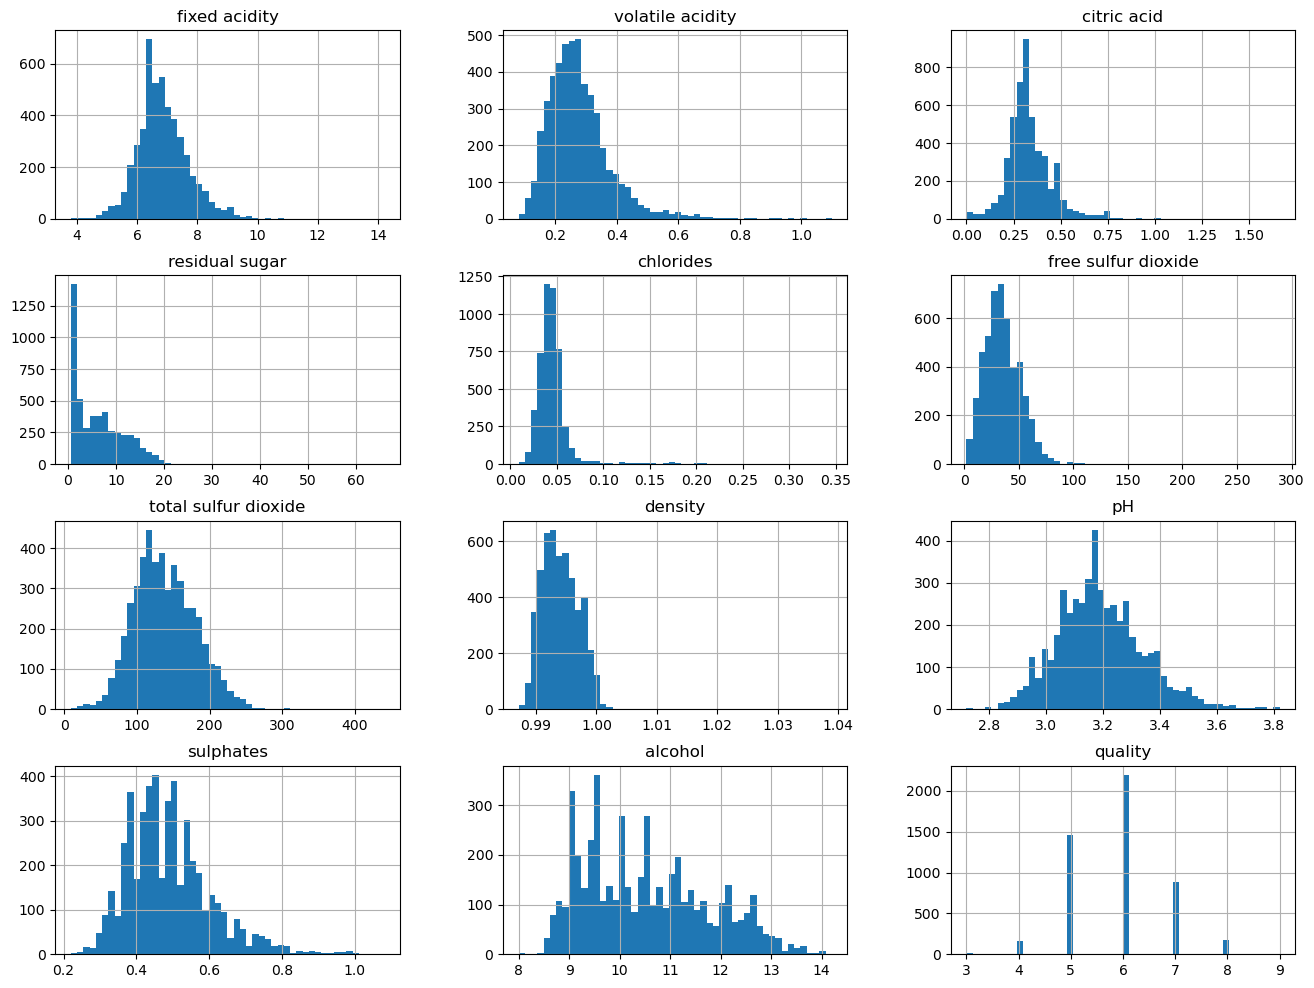

In [129]:
# Plot histogram of each feature for white wine
df_white.hist(bins=50, figsize=(16,12))
plt.show()

In [130]:
# Split data into training and test sets
train_w, test_w = train_test_split(df_white, test_size = 0.2, random_state = 42)
train_r, test_r = train_test_split(df_red, test_size = 0.2, random_state = 42)

X_test = test_w.copy().drop("quality", axis=1)
Y_test = test_w["quality"]
X_train = train_w.copy().drop("quality", axis=1)
Y_train = train_w["quality"]

# Stratified sampling (?)

In [131]:
# Function to try different attribute combinations 
def make_attr_combos(df, cols):
    new_cols = []
    new_col_names = []
    
    for attr_1 in cols:
        for attr_2 in cols:
            if (attr_1 != attr_2):
                col_name = attr_1 + "/" + attr_2
                new_col_names.append(col_name)
                new_attr = df[attr_1]/df[attr_2]
                new_cols.append(list(new_attr.values))
    
    new_cols = np.array(new_cols).transpose()
    new_attrs_df = pd.DataFrame(new_cols, columns = new_col_names)

    return new_attrs_df

In [132]:
# Features to be transformed:
transform_cols = ["residual sugar", "alcohol"]

# Create and apply log transform for heavy tail distributions
log_transform = FunctionTransformer(np.log1p, validate=True)
X_train_transform = log_transform.transform(X_train[[transform_cols[0]]])
X_train_transform = pd.DataFrame(X_train_transform, columns = [transform_cols[0]])

# Create similarity feature for multimodal distributions
# New similarity feature for each mode: [9, 9.5, 10, 10.5]
modes = [9, 9.5, 10, 10.5]
alc_sim_features = []

for mode in modes:
    new_feature = rbf_kernel(X_train[[transform_cols[1]]], [[mode]], gamma=0.1)
    alc_sim_features.append(new_feature)

print("before concat")
print(X_train_transform.shape)
print(X_train.shape)
# Combine transformed features into a single dataframe
alc_sim_features = np.array(alc_sim_features).reshape(4, 3918).transpose()
temp_df = pd.DataFrame(alc_sim_features, columns = ["sim_to_" + str(x) for x in modes])
X_train_transform = pd.concat([X_train_transform, temp_df], axis=1)
print("after concat")
print(X_train_transform.shape)
# Plot histogram of each transformed feature
#X_train_transform.hist(bins=50, figsize=(16,12))
#plt.show()

before concat
(3918, 1)
(3918, 11)
after concat
(3918, 5)


/Users/umarjara/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [133]:
# Scale the rest of the features
# Swap in the transformed features
X_train = X_train.drop(columns = transform_cols)
X_train = pd.concat([X_train, X_train_transform], axis=1)
#X_train
print(X_train.shape)
print(X_train_transform.shape)

# Min-max scaling


(4702, 14)
(3918, 5)


In [107]:
print(X_train.shape)
print(X_train_transform.shape)


(3134, 14)
(3918, 5)


In [142]:
# Find top 3 feature correlations to quality
corr_matrix = train_w.corr()
corr_high = corr_matrix["quality"].sort_values(ascending=False)[1:4]
corr_high_cols = corr_high.axes[0]
corr_high_cols
# Create new features

# Find top 3 correlations from new features

Index(['alcohol', 'pH', 'sulphates'], dtype='object')

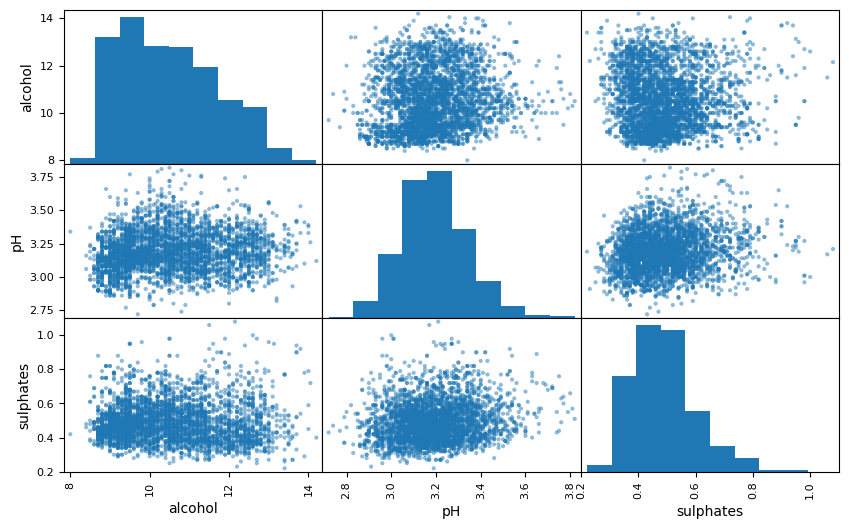

In [19]:
# Plot top 4 correlations in a scatter matrix
scatter_matrix(train_w[corr_high_cols], figsize=(10,6))
plt.show()

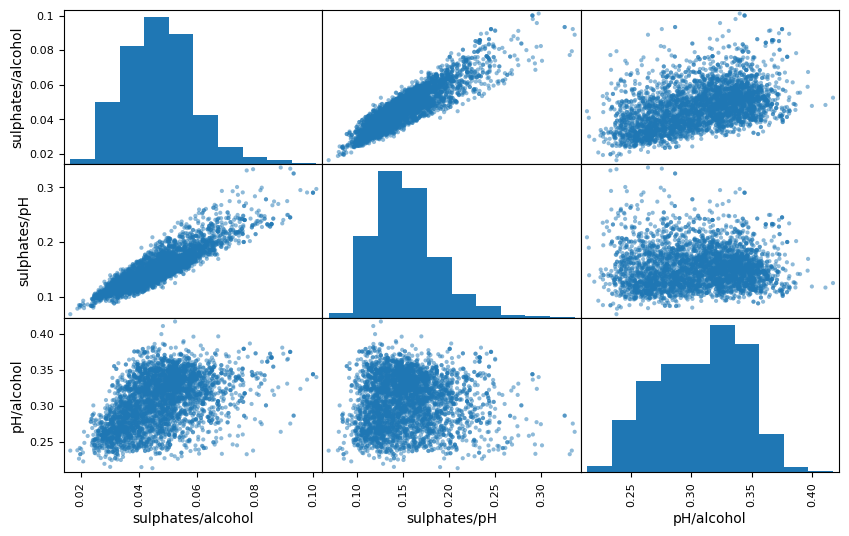

In [20]:
# Plot top 4 new correlations in a scatter matrix
scatter_matrix(new_attrs_df[new_corr_high_cols], figsize=(10,6))
plt.show()

More feature engineering/selection
View feature combinations
Scale/normalize features
Decision trees

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [34]:
# Lower bound linear regression model

# Separate features from labels
X_test = test_w.copy().drop("quality", axis=1)
Y_test = test_w["quality"]
X_train = train_w.copy().drop("quality", axis=1)
Y_train = train_w["quality"]

# Fit the model
lin_r = LinearRegression()
lin_r.fit(X_train, Y_train)

# Compare predictions
pred = lin_r.predict(X_test).round()
correct = pred[:5]
predicted = Y_test.iloc[:5].values

[6. 6. 6. 6. 6.]
[7. 8. 8. 5. 7.]


In [35]:
# View error

lin_rmse = mean_squared_error(Y_test, pred, squared=False)
print(lin_rmse)

0.8137843067786351


In [38]:
# Polynomial regression

# Transform data for new polynomial featurs (degree 2)
poly_2 = PolynomialFeatures(2)
X_train_poly_2 = poly_2.fit_transform(X_train)
X_test_poly_2 = poly_2.fit_transform(X_test)

# Fit model and predict
lin_r2 = LinearRegression()
lin_r2.fit(X_train_poly_2, Y_train)
pred_poly_2 = lin_r2.predict(X_test_poly_2).round()

print(mean_squared_error(Y_test, pred_poly_2, squared=False))

0.8409178658720822
1.2661205410583132
10.95277432005802


## Safe Mushrooms EDA (Classification task)

In [2]:
from sklearn.preprocessing import OrdinalEncoder

In [3]:
# Import data from local files
df_shroom = pd.read_csv('Data/mushrooms.csv')
df_shroom

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [4]:
# Encode categorical features (all of them) with ordinal encoding
ord_encoder = OrdinalEncoder()
shroom_encoded = ord_encoder.fit_transform(df_shroom)
df_shroom_encoded = pd.DataFrame(shroom_encoded, columns = df_shroom.columns)
df_shroom_encoded 

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1.0,5.0,2.0,4.0,1.0,6.0,1.0,0.0,1.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,2.0,3.0,5.0
1,0.0,5.0,2.0,9.0,1.0,0.0,1.0,0.0,0.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,3.0,2.0,1.0
2,0.0,0.0,2.0,8.0,1.0,3.0,1.0,0.0,0.0,5.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,3.0,2.0,3.0
3,1.0,5.0,3.0,8.0,1.0,6.0,1.0,0.0,1.0,5.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,2.0,3.0,5.0
4,0.0,5.0,2.0,3.0,0.0,5.0,1.0,1.0,0.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0.0,3.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,11.0,...,2.0,5.0,5.0,0.0,1.0,1.0,4.0,0.0,1.0,2.0
8120,0.0,5.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,11.0,...,2.0,5.0,5.0,0.0,0.0,1.0,4.0,0.0,4.0,2.0
8121,0.0,2.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,5.0,...,2.0,5.0,5.0,0.0,1.0,1.0,4.0,0.0,1.0,2.0
8122,1.0,3.0,3.0,4.0,0.0,8.0,1.0,0.0,1.0,0.0,...,1.0,7.0,7.0,0.0,2.0,1.0,0.0,7.0,4.0,2.0


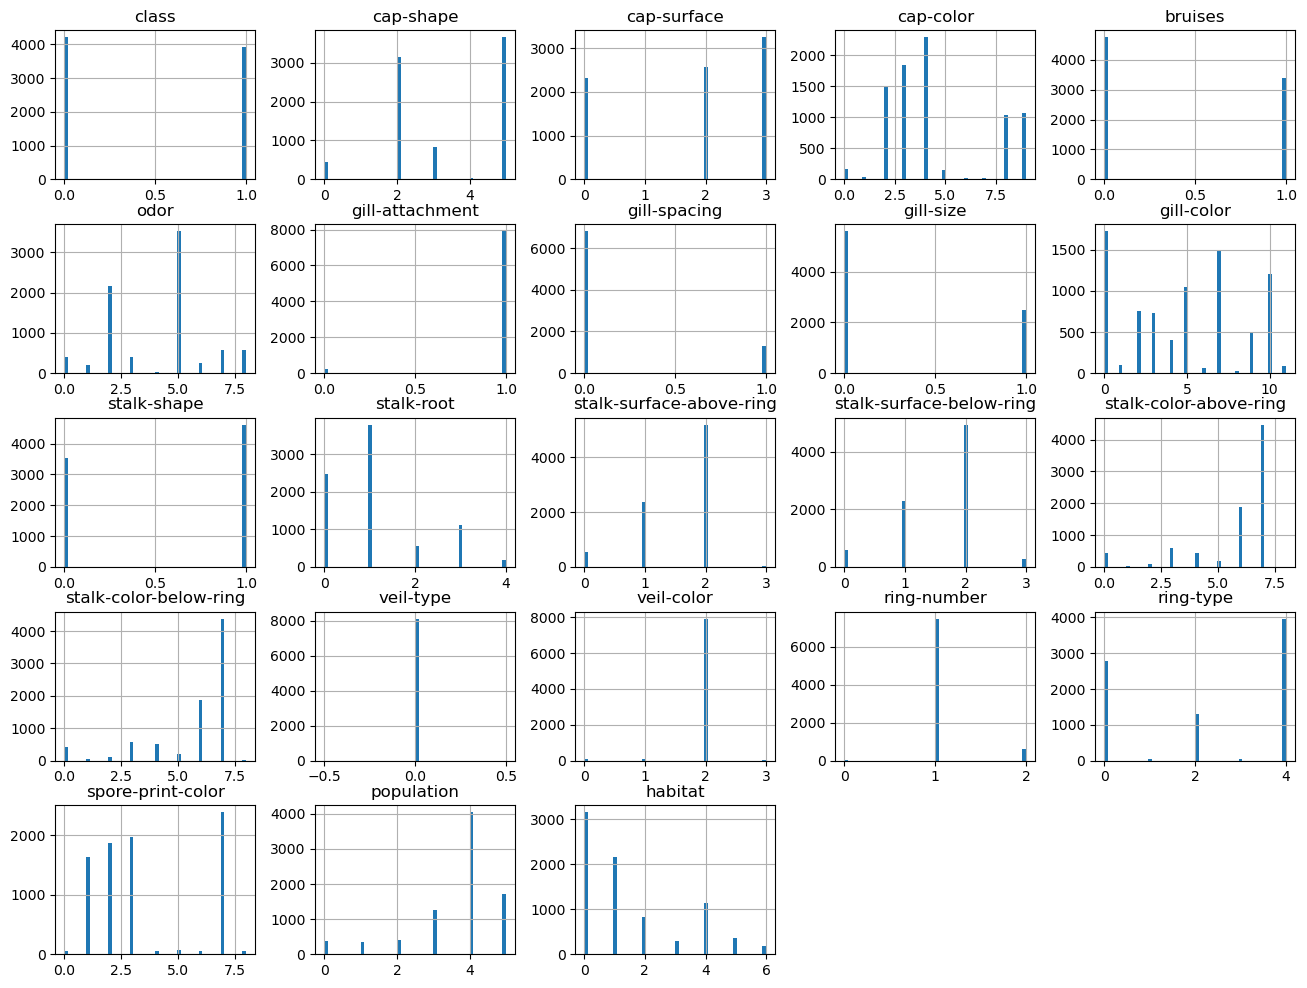

In [5]:
# Plot histogram of mushroom features
df_shroom_encoded.hist(bins=50, figsize=(16,12))
plt.show()

In [6]:
# Find features with little variance (just veil-type)
bad_features = [col for col in df_shroom_encoded.columns if len(df_shroom_encoded[col].unique()) == 1]

# Drop bad features
df_shroom_encoded = df_shroom_encoded.drop(bad_features, axis = 1)

# Split training data
train_m, test_m = train_test_split(df_shroom_encoded, test_size = 0.2, random_state = 42)

In [7]:
# Examine correlations
corr_matrix = train_m.corr()

# View attributes most to least correlated with class and get the top 4
corr_sorted = corr_matrix["class"].sort_values(ascending=False)
corr_high_cols = list(corr_sorted[1:4].axes[0])
print(corr_sorted[1:4].axes[0])

Index(['gill-size', 'population', 'habitat'], dtype='object')


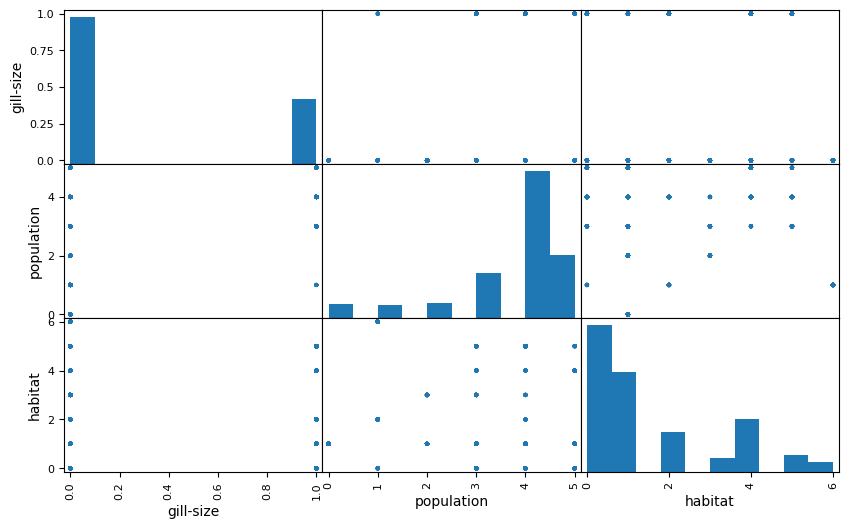

In [73]:
# Plot top 4 correlations in a scatter matrix
scatter_matrix(train_m[corr_high_cols], figsize=(10,6))
plt.show()